# LangGraph 시작하기

랭그래프로 간단한 LLM application (챗봇) 을 만들어봅시다

- 웹을 서치하고 대답하는 챗봇
- 대화의 내용을 저장하고 이어가는 챗봇
- Route complex queries to a human for review
- Use custom state to control its behavior
- Rewind and explore alternative conversation paths


## Setup

필요한 패키지들을 설치합니다

In [ ]:
%%capture --no-stderr
%pip install -U langgraph langsmith

# 본 실습을 위해서 다운을 받습니다.
%pip install -U langchain-openai

API key 를 셋팅합니다.
OPENAI 에서 발급받아오세요

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY: ··········


[LangSmith](https://docs.smith.langchain.com) 도 셋업을 하겠습니다.  
앞으로 작성할 LangGraph 의 동작을 추적하여 볼 수 있습니다.  

LangSmith 에 대한 내용은 [튜토리얼 문서](https://jonhpark7966.github.io/LangSmith_Course/intros/LangSmith/) 를 참조하세요



In [ ]:
os.environ["LANGCHAIN_TRACING_V2"]="true"

_set_env("LANGCHAIN_API_KEY")

LANGCHAIN_API_KEY: ··········


## 1. 정말 간단한 챗봇 (GPT Wrapper) 만들기

LangGraph 로 GPT API 를 보내고 답변 받는 챗봇을 만들어 봅시다.

 - `StateGraph`를 먼저 만들겠습니다.
   -  `StateGraph` 오브젝트는 우리의 챗봇을 "state machine" 으로 정의합니다.
   
 - `nodes` 들을 추가합니다. LLM 기능을 정의하고,  `edges` 를 연결하여 어떻게 동작할 지 추가가 가능합니다.

In [ ]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


# 1. State 를 정의합니다.
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# 2. 노드를 정의합니다.
llm = ChatOpenAI(model="gpt-4o-mini")
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# 3. 그래프를 정의합니다.
# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()

**참고**

가장 처음 해야할 일을 ```State``` 를 정의하는 것 입니다.  
```State``` 는 그래프의 스키마를 가지고 있고, 상태를 업데이트랑 리듀서 함수들을 붙입니다.  

이번 예시에서는 ```messages```만 가지고 있는```TypedDict``` 가 ```State``` 입니다.  
```messages```  는 [add_messages](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_message) 리듀서 함수를 가지고 있습니다.   
LangGraph 에서는 새로운 메세지를 추가하거나 덮어쓰는 것이 가능합니다.  

자세한 내용은 컨셉가이드를 참고하세요.


1. 모든 `node` 는 앞으로 현재 `State` 를 받아서 업데이트하고 리턴합니다.
2. `messages`는 현재 리스트에 _appended_ 될 것입니다, [`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) 함수를 `Annotated` 에 추가 했기 때문이고요, 챗봇이니까 메세지가 쌓여야 겠죠.

이제 "`chatbot`" 노드를 추가합니다.

`chatbot` 노드는 현재 `State` 를 인풋으로 받아서 업데이트하고 리턴합니다. 실제로는 'State' 의 'messages' 스키마가 업데이트가 되겠죠. LangGraph 의 기본 패턴입니다.


이제 `entry` 와 'finish' 포인트를 추가해서 시작점과 끝을 만들어 줍니다.

`finish` 포인트는 그래프가 **"언제나 이 노드가 수행중일때 끝낼 수 있음을 알립니다. (any time this node is run, you can exit.)"**

 "`compile()`" 까지 불러줘야 사용 가능 합니다. "`CompiledGraph`" 가 되어야 호출이 가능합니다.

시각화해서 그래프를 볼 수도 있습니다. `get_graph`& `draw` 함수로 그려볼 수 있습니다.

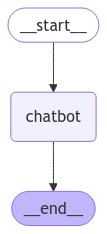

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 수행시켜 보죠.

**Tip:**  "quit", "exit", or "q". 를 입력해서 끝낼 수 있습니다.

In [ ]:
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": ("user", user_input)}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

User: 저녁 메뉴 추천 좀
Assistant: 저녁 메뉴로 몇 가지 추천해드릴게요!

1. **불고기**: 달콤하고 짭짤한 소고기 불고기를 쌈 채소와 함께 드시면 좋습니다.
2. **비빔밥**: 다양한 야채와 고기를 넣고 고추장과 함께 비벼 먹는 비빔밥은 영양가도 높고 맛있어요.
3. **김치찌개**: 구수한 김치찌개에 밥 한 공기면 속이 든든해집니다.
4. **치킨**: 바삭한 프라이드 치킨이나 매콤한 양념 치킨도 좋은 선택입니다.
5. **해물파전**: 해물과 파가 가득한 전은 간단하면서도 맛있는 저녁 메뉴입니다.
6. **파스타**: 크림 소스나 토마토 소스로 간단하게 만들 수 있는 파스타도 추천해요.
7. **샐러드**: 가벼운 저녁을 원하신다면 신선한 채소와 단백질을 곁들인 샐러드도 좋습니다.

어떤 메뉴가 마음에 드시나요?
User: q
Goodbye!


## 2. 챗봇에 도구를 추가해주기

현재 챗봇 (LLM) 이 당연히 본인 "기억" 만 가지고는 대답을 못 할 수 있습니다. 그러니 웹 서칭 도구를 손에 쥐어주고 검색해오라고 해보겠습니다. 관련 정보를 알아서 검색해서 더 잘 답변해 주겠죠.

#### Requirements

필요 패키지랑 API 키를 셋업하겠습니다.

[Tavily Search Engine](https://python.langchain.com/v0.2/docs/integrations/tools/tavily_search/) 와 [TAVILY_API_KEY](https://tavily.com/) 를 셋업하겠습니다.  

Tavily 는 웹 서칭을 api 로 연결시켜주는 도구 입니다.

In [ ]:
%%capture --no-stderr
%pip install -U tavily-python
%pip install -U langchain_community

In [ ]:
_set_env("TAVILY_API_KEY")

TAVILY_API_KEY: ··········


`tool` 을 정의하고, 사용해보겠습니다

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'url': 'https://medium.com/@cplog/introduction-to-langgraph-a-beginners-guide-14f9be027141',
  'content': 'Nodes: Nodes are the building blocks of your LangGraph. Each node represents a function or a computation step. You define nodes to perform specific tasks, such as processing input, making ...'},
 {'url': 'https://saksheepatil05.medium.com/demystifying-langgraph-a-beginner-friendly-dive-into-langgraph-concepts-5ffe890ddac0',
  'content': 'Nodes (Tasks): Nodes are like the workstations on the assembly line. Each node performs a specific task on the product. In LangGraph, nodes are Python functions that take the current state, do some work, and return an updated state. Next, we define the nodes, each representing a task in our sandwich-making process.'}]

검색결과 미디엄에서 관련 글을 찾았고, 내용을 parsing 해서 text 의 형태로 리턴해 줍니다.

이제 Tavily search tool 을 위쪽 1번 파트에서 만든 chatbot langgraph 에 이어 붙여보겠습니다.  

1. `tool`을 정의합니다.
2. `llm.bind_tools()` 를 이용해서 tool 을 추가해줍니다.
3. `ToolNode`를 정의하고 노드로 추가해줍니다.
4. `add_conditional_edges()` & `tools_condition` 을 추가해서 LLM이 직접 tool 을 사용할지 안할지 판단하도록 합니다.
  - `add_conditional_edge()` 는 end point 가 포함되어 있기 때문에, 직접 지정할 필요가 없습니다.

In [ ]:
# 파트 1 에서 이어지는 코드 입니다
graph_builder = StateGraph(State)

from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import START


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

graph_builder.add_edge("tools", "chatbot")

#graph_builder.set_entry_point("chatbot")
graph_builder.add_edge(START, "chatbot")

# conditional_edges() 가 알아서 끝낼수 있기 때문에 끝을 지정 안 해줘도 됩니다.
# graph_builder.set_finish_point("chatbot")

graph = graph_builder.compile()

이렇게 생성된 그래프를 보면 아래와 같이 표현됩니다.  
conditional edge 가 생겨서 tool을 사용하거나 안하거나, 결정이 가능합니다.

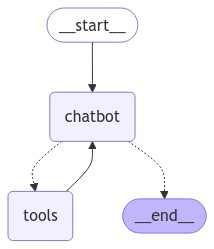

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

chatbot 의 형태로 채팅을 해보겠습니다. 과연 tool을 잘 사용해서 대답할 수 있을까요?

In [ ]:
from langchain_core.messages import BaseMessage

while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            if isinstance(value["messages"][-1], BaseMessage):
                print("Assistant:", value["messages"][-1].content)

User: 저녁 메뉴 추천 좀
Assistant: 저녁 메뉴로는 여러 가지가 있겠지만, 몇 가지 추천드릴게요:

1. **비빔밥**: 다양한 채소와 고기, 계란을 섞어 먹는 건강한 한 그릇 요리입니다.
2. **김치찌개**: 뜨끈하고 매콤한 김치찌개는 밥과 함께 먹기 좋은 메뉴입니다.
3. **불고기**: 양념한 소고기를 구워서 먹는 불고기는 간단하면서도 맛있는 저녁으로 좋습니다.
4. **해물파전**: 해물과 파를 넣어 부친 전을 막걸리와 함께 즐기면 좋습니다.
5. **닭갈비**: 매콤한 양념의 닭고기와 채소를 볶아 먹는 닭갈비도 훌륭한 선택입니다.

어떤 메뉴가 끌리시나요? 추가적으로 다른 추천이 필요하시면 말씀해 주세요!
User: 저녁 메뉴 요즘 유행하는 것을 웹에서 검색해서 추천해줘
Assistant: 
Assistant: [{"url": "https://ranknews.co.kr/저녁메뉴-추천-best20/", "content": "오늘은 저녁 메뉴 추천 BEST 20에 대해서 알려드리려고 합니다. 사실 저도 퇴근하고 나면 만사가 귀찮아질 때가 많아서, 가장 만족스러운 저녁 메뉴를 빠르게 고를 수 있도록 준비해 보았습니다. 자취 5년 차이니 저를 믿어보셔도 좋습니다. 배달의 민족이라는 ..."}, {"url": "https://m.blog.naver.com/next200208/222957667466", "content": "2023 외식업트렌드는 2020년부터 진행해온 2022 배민 외식업 컨퍼런스에서 최초 공개되었습니다. 올해 행사는 '22.12.13 (화)~12.14 (수) 양일간, 바쁜 사장님들이 쉽게 접근하고자 역시 온라인으로 진행되었는데요. 이번 컨퍼런스에 김난도 교수가 직접 나와, 무려 80분 ..."}]
Assistant: 요즘 유행하는 저녁 메뉴 추천에 대한 정보를 찾았습니다. 아래 링크들을 통해 다양한 추천 메뉴를 확인해보실 수 있습니다.

1. [저녁 메뉴 추천 BEST 20](https://ranknews.co.kr/저녁메뉴-추

1. 첫 질문인 **저녁 메뉴 추천 좀** 이라는 질문에 대해서는 tavily 의 검색 없이 대답을 했습니다.
  - 아래 Langsmith 로 [추적된 결과](https://smith.langchain.com/public/02c63454-e401-4cbf-a488-9230d634b488/r)를 첨부합니다.

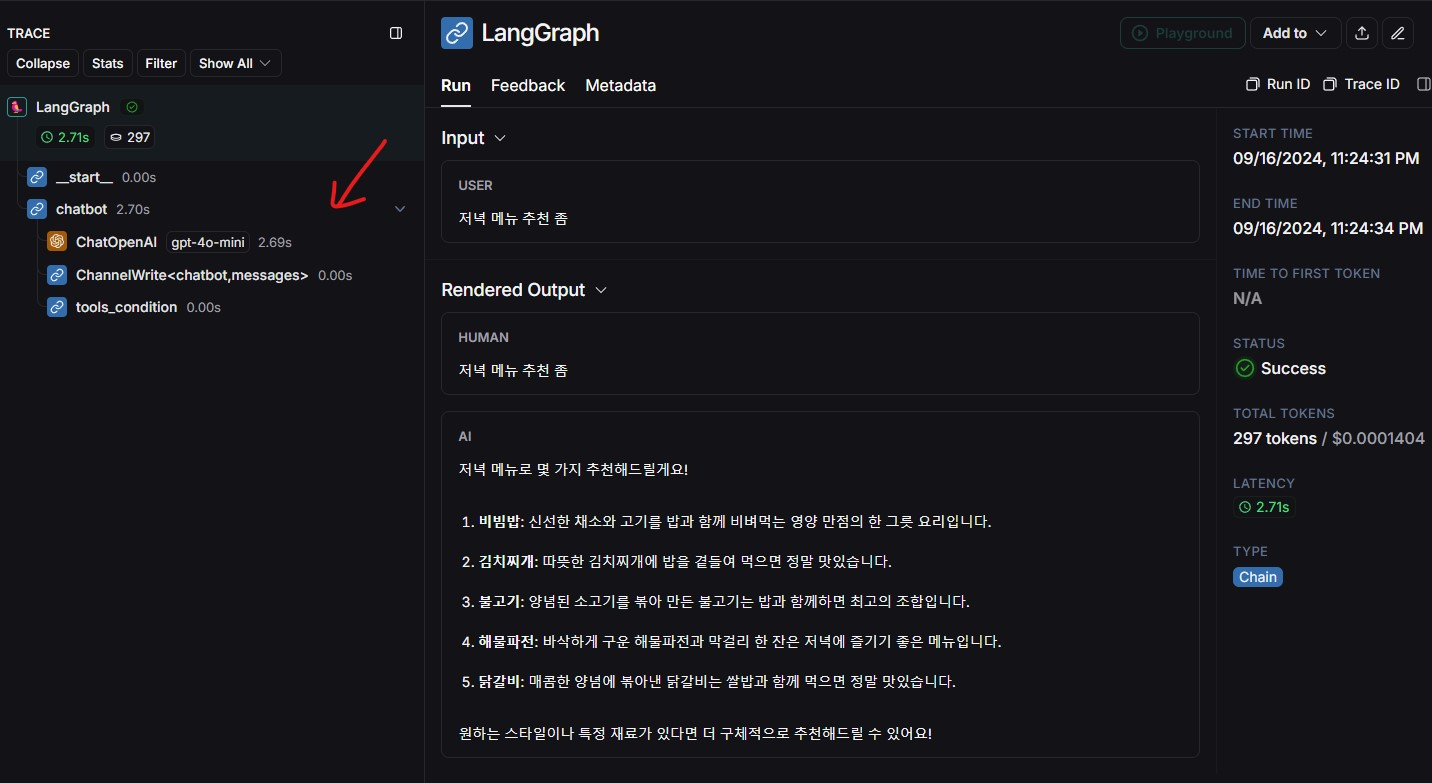

2. 추가 질문인 **저녁 메뉴 요즘 유행하는 것을 웹에서 검색해서 추천해줘** 에 대해서는 tavily 검색 결과와 함께 답변을 해 줬습니다.
  - 역시나, 아래 Langsmith 로 [추적된 결과](https://smith.langchain.com/public/5d4bb3d2-ff0c-4406-9bdf-3cfcb2cb3db1/r)를 첨부합니다.

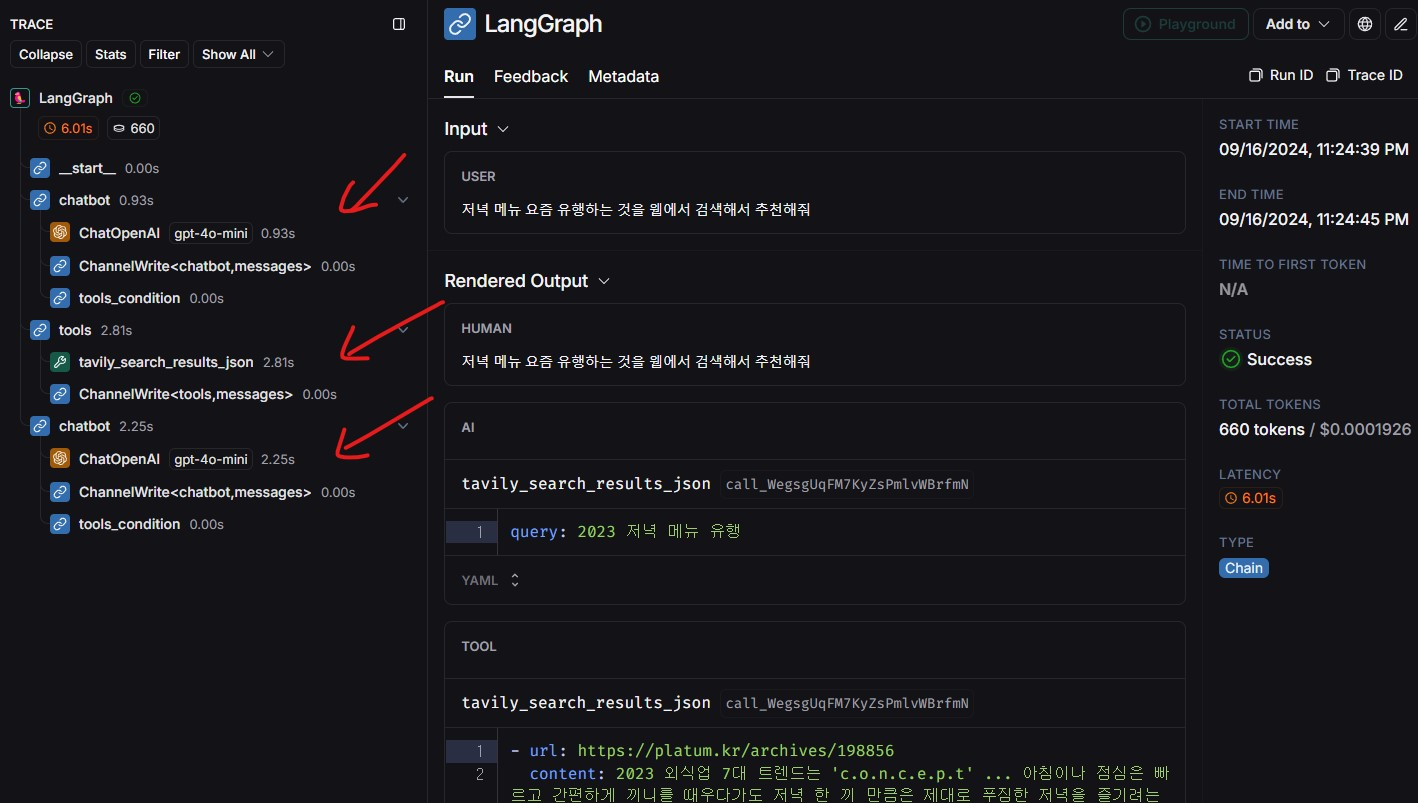

검색결과 platum.kr 도메인의 외식업 트렌드 글을 참고해서 대답을 했습니다. 정말로 만족스러운 저녁 메뉴를 추천해줬는지는 모르겠지만, 어쨌든 도구의 도움과 함께 답변을 했습니다.  

> 원하던대로 웹서칭 도구를 잘 쥐어 주었군요!

이런것이 어떻게 가능할까요...??
  - 추적을 보면, tavily 에 날릴 쿼리를 LLM (여기서는 gpt-4o-mini) 이 알아서 뽑아서 요청하고 옵니다.
  - 우리가 사용한 LLM은 ChatOpenAI, LangChain 의 chat 모델입니다. 여기서 tool calling 을 지원합니다.
  - 아래 링크를 보면, chat 모델마다 tool calling 의 지원 여부를 볼 수 있습니다.
    - 참조 - https://python.langchain.com/docs/integrations/chat/?ref=blog.langchain.dev


## 3. 챗봇에 메모리 추가하기

챗봇은 웹 서칭이 가능하지만, 대화를 이어나가려면 메모리를 가지고 있어야 하겠죠. 메모리를 추가해줘서 멀티턴 대화에 일관성을 부여하도록 하겠습니다.  

LangGraph 는 **persistent checkpointing** 이라는 개념으로 이 메모리 문제를 해결합니다. `checkpointer` 를 그래프 컴파일 할때 넣어주고, `thread_id` 를 그래프 호출할 때 사용하면, LangGraph 가 자동으로 state 를 기억하고 넘겨줍니다. 같은 `thread_id` 로 그래프를 호출하면, 저장된 state 를 로딩하여 이어갑니다.  

**checkpointing** 은 단순 메모리보다는 **훨씬 더** 파워풀한 방법입니다.  
복잡한 state를 저장하고, 재개 하는 기능이기 때문에,
  - error recovery
  - human-in-the-loop workflows
  - time travel interactions, and more
와 같은 기능들을 구현 가능하게 합니다.  

우선은 멀티턴 대화를 위한 메모리 기능으로 부터 시작해보겠습니다.

`MemorySaver` checkpointer 를 만들면서 시작하죠.

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

**참고**   
이 문서에서는 In-memory checkpointer 를 사용합니다. 여기서의 "in-memory" 는 프로세스의 메모리, RAM 을 의미합니다. 튜토리얼 자료로서는 이정도로 충분하지만, 당연히 프로세스가 꺼지면, 정보가 모두 날아갑니다.  
상업 (production) 레벨에서는 `SqliteSaver` 나 `PostgresSaver`를 사용하고 DB 에 연결하는 것을 추천합니다.



In [ ]:
# 파트2 에서 작성한 그래프에 checkpointer 만 추가하여 다시 만듧니다.

graph = graph_builder.compile(checkpointer=memory)

그래프를 시각화해보면, 노드가 달라진 것은 없습니다.

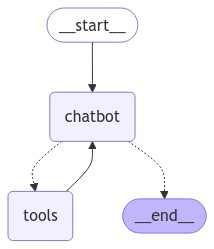

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

대화에 쓰레드 아이디를 할당하고 챗봇을 사용해 봅시다.

In [ ]:
config = {"configurable": {"thread_id": "1"}}

In [ ]:
user_input = "안녕안녕, 나는 점심에 경양식 돈까쓰를 먹었어."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕안녕, 나는 점심에 경양식 돈까쓰를 먹었어.
================================== Ai Message ==================================

안녕하세요! 경양식 돈까스를 드셨다니 맛있겠네요. 돈까스는 바삭한 튀김과 부드러운 고기가 조화를 이루어서 정말 맛있죠. 어떤 소스와 함께 드셨나요?


**Note:** The config was provided as the **second positional argument** when calling our graph. It importantly is _not_ nested within the graph inputs (`{'messages': []}`).

Let's ask a followup: see if it remembers your name.

In [ ]:
user_input = "나 점심에 뭐 먹었지?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

나 점심에 뭐 먹었지?
================================== Ai Message ==================================

점심에 경양식 돈까스를 드셨다고 하셨습니다! 아주 맛있는 선택이었네요. 다른 메뉴도 고려하셨나요?


앞선 대화를 잘 기억을 했습니다. [LangSmith trace](https://smith.langchain.com/public/b346e9b8-d738-438a-9e07-9ef73ea0f9a5/r) 를 보시면, 대화가 이어져 있는 것을 볼 수 있습니다. 링크의 화면은 캡처해서 아래 첨부합니다.


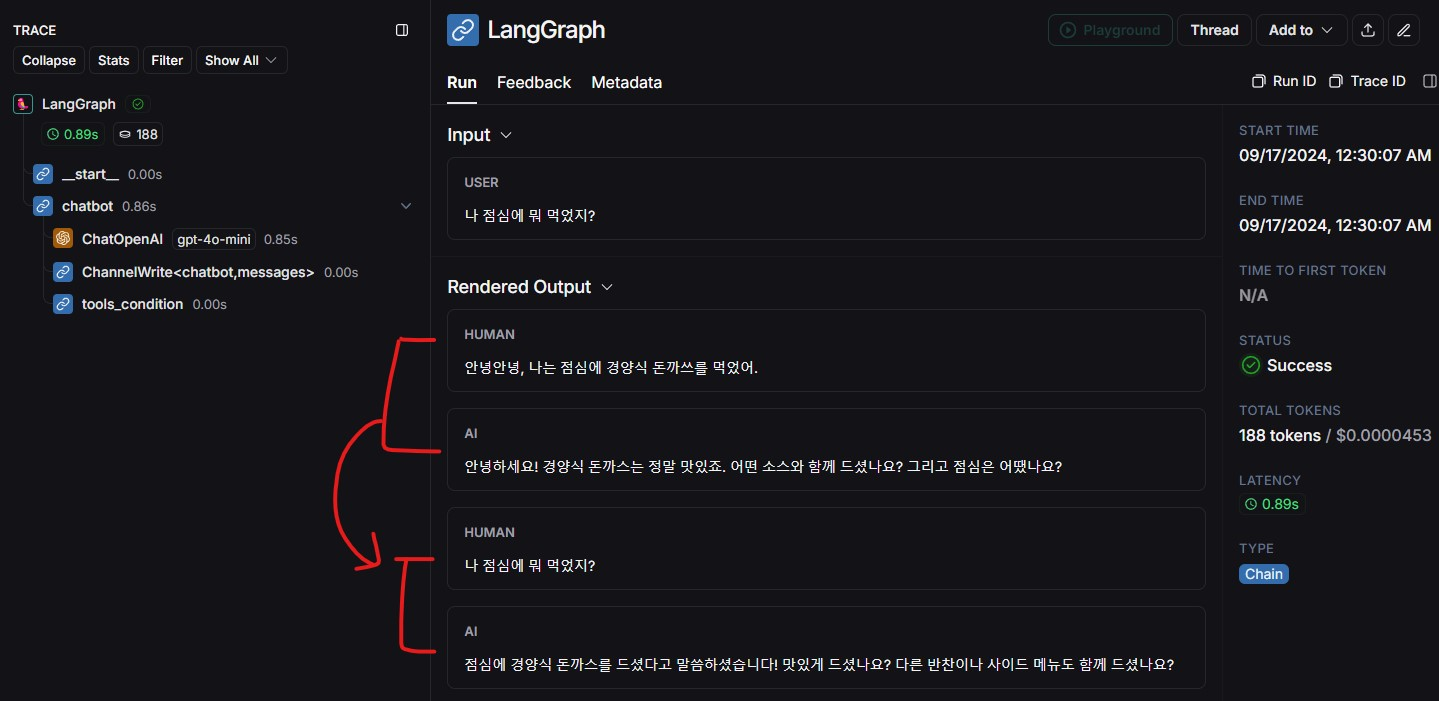

In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [("user", user_input)]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

나 점심에 뭐 먹었지?
================================== Ai Message ==================================

죄송하지만, 당신이 점심에 무엇을 먹었는지 알 수 있는 방법이 없습니다. 혹시 기억이 나지 않거나 도움이 필요한 다른 질문이 있으시면 말씀해 주세요!


`thread_id` 를 바꿔주니, 대화를 기억을 못하네요.

Checkpoint 에서 무슨 일이 일어나고 있는지 보고 싶다면, graph의 `state` 를 `get_state(config)` 함수 호출해서 보면 됩니다.

In [ ]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='안녕안녕, 나는 점심에 경양식 돈까쓰를 먹었어.', additional_kwargs={}, response_metadata={}, id='e4e5df43-1506-4ed6-b174-c7c46df52c7b'), AIMessage(content='안녕하세요! 경양식 돈까스를 드셨다니 맛있겠네요. 돈까스는 바삭한 튀김과 부드러운 고기가 조화를 이루어서 정말 맛있죠. 어떤 소스와 함께 드셨나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 53, 'prompt_tokens': 99, 'total_tokens': 152, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'stop', 'logprobs': None}, id='run-26d8ef2f-aedc-4593-b0c7-73bd66d01b2e-0', usage_metadata={'input_tokens': 99, 'output_tokens': 53, 'total_tokens': 152}), HumanMessage(content='나 점심에 뭐 먹었지?', additional_kwargs={}, response_metadata={}, id='82514da5-863d-4a44-a5d7-cd75be780098'), AIMessage(content='점심에 경양식 돈까스를 드셨다고 하셨습니다! 아주 맛있는 선택이었네요. 다른 메뉴도 고려하셨나요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'co

In [ ]:
snapshot.next  # (since the graph ended this turn, `next` is empty. If you fetch a state from within a graph invocation, next tells which node will execute next)

()

스냅샷은 넘겨준 config (thread_id) 의 현재 state 값을 가지고 있고요,  
다음으로 실행할 `next` 노드를 가리키고 있습니다.  
여기서는  `__end__` 에 도달해서 `next` 가 없어요.

여기까지 체크포인트를 대화의 기억을 구현하도록 사용했습니다.  
다음은 사람의 개입 (Human in the loop) 을 구현해보겠습니다.

## 4. Human-in-the-loop

당연한 이야기 이지만, Agent 는 unreliable, 믿을 수가 없어요. 부하직원이라고 생각하면 되는데, 사람도 부하직원이 실수할 것을 대비해야하죠?  
그래서 어떤 일을 시키고, 중간에 개입해서 체크를 해야합니다.  
승인 과정을 시스템에 넣어두는 것과 비슷하죠.  

LangGraph 는 `human-in-the-loop` workflows 를 여러가지 방법으로 지원합니다. 이번 실습에서는 LangGraph의 `interrupt_before` 기능을 사용해서 노드 실행 전마다 모두 멈춰서 사람이 개입하도록 해보겠습니다.

참고로, 이 Human-in-the-loop 기능이 LangGraph 이전 LangChain 에서는 구현이 어려워서 많은 개발자들의 불만을 샀었습니다.



> 여기서 잠깐! LangGraph Studio 를 사용하면, 아주 쉽게 인터럽트를 UX 와 함께 구현 할 수 있습니다. 24.9.30 기준 MAC OS 만 베타로 지원합니다.



그래프를 컴파일 할때, `interrupt_before`  를 `tools` 노드에다가 넣겠습니다.

In [ ]:
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],

    # Note: can also interrupt __after__ tools, if desired.
    # interrupt_after=["tools"]
)

In [ ]:
user_input = "나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?"
config = {"configurable": {"thread_id": "1"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_56EmA9jt3tcBF09z4sVslldv)
 Call ID: call_56EmA9jt3tcBF09z4sVslldv
  Args:
    query: 랭그래프(Leung graph) 개념 및 활용


`get_state()` 를 해서 다음 스탭을 보겠습니다.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

**Notice**  
아까 위에서는 next 가 비어있었죠. 이번에는 next 에  **'tools'** 가 있습니다. 중간 단계에서 잘 멈췄다는 뜻이죠.

In [ ]:
existing_message = snapshot.values["messages"][-1]
existing_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': '랭그래프(Leung graph) 개념 및 활용'},
  'id': 'call_56EmA9jt3tcBF09z4sVslldv',
  'type': 'tool_call'}]

Tools 인 Tavily 로 검색을 날릴 예정인데, 쿼리를 내보낼 검색어가 나쁘지 않은 것 같아요, 별다른 수정없이 그대로 진행 시켜 보겠습니다.  


In [ ]:
# `None` will append nothing new to the current state, letting it resume as if it had never been interrupted
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_56EmA9jt3tcBF09z4sVslldv)
 Call ID: call_56EmA9jt3tcBF09z4sVslldv
  Args:
    query: 랭그래프(Leung graph) 개념 및 활용
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://gunn.kim/langgraph-vs-langchain-evolution-of-llm-development-frameworks", "content": "대규모 언어 모델(LLM) 기반 애플리케이션 개발이 급증하면서 랭체인(LangChain)과 랭그래프(LangGraph)가 주목받고 있습니다. 이 글에서는 두 프레임워크의 특징, 차이점, 그리고 실제 적용 사례를 살펴봅니다. AutoGPT와의 유사성을 통해 각 프레임워크를 이해하고, 나스닥 지수 분석 및 포트폴리오 최적화 ..."}, {"url": "https://livewiki.com/ko/content/learn-langgraph-easy-way", "content": "LangGraph 앱을 사용하면 그래프 구조를 사용하여 사용자 쿼리를 처리하고 응답하는 에이전트 애플리케이션 또는 LLM 애플리케이션을 만들 수 있습니다."}]
================================== Ai Message ==================================

랭그래프(Leung graph)에 대한 정보는 다음과 같습니다:

1. **랭그래프와 랭체인**:
   - 최근 대규모 언어 모델(LLM) 기반 애플리케이션 개발이 활발해지면서 랭체인(

**첨언**

검색결과가 매우 마음에 안들기는 합니다... 포스트가 AI generated content 인 것 같군요. 피규어도 깨져있고, 자세히 읽어보면 틀린 내용도 많습니다. 아마 대부분은 눈치채지 못할테지만요.  
Human-in-the-loop 이 이런 검색 결과에서 리젝하고 싶은 것들을 거르기 위한 방법으로도 잘 쓰일 것 같은데, After Tool 에 인터럽트를 걸어서 한번 거절하도록 해볼까요?

## 5. State 변경하기

앞선 실습에서는 interrupt 를 걸고, state를 봤습니다. `read` 만 했죠. 이번에는 `write`를 해서 state 를 마음대로 변경해보겠습니다.  

LangGraph 는 **manually update state** 가 가능합니다. agent 가 원치 않는 동작을 못하도록 막거나, 변경시키거나 다양하게 활용이 가능합니다.

Checkpointed state 를 직접 변경 시켜보도록 하겠습니다.

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # This is new!
    interrupt_before=["tools"],
    # Note: can also interrupt **after** actions, if desired.
    # interrupt_after=["tools"]
)

user_input = "나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?"
config = {"configurable": {"thread_id": "3"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream({"messages": [("user", user_input)]}, config)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

In [ ]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_N9E5wxGaTBpZudPU5IkiRBac)
 Call ID: call_N9E5wxGaTBpZudPU5IkiRBac
  Args:
    query: 랭그래프 랭킹 그래프 공부


In [ ]:
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?', additional_kwargs={}, response_metadata={}, id='e7ce0efa-ef12-41f0-b5f5-eb662a0e8902'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_N9E5wxGaTBpZudPU5IkiRBac', 'function': {'arguments': '{"query":"랭그래프 랭킹 그래프 공부"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 97, 'total_tokens': 124, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_54e2f484be', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-76b993a2-cfcd-42a6-870a-70bb44080fd4-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': '랭그래프 랭킹 그래프 공부'}, 'id': 'call_N9E5wxGaTBpZudPU5IkiRBac', 'type': 'tool_call'}], usage_metadata={'input_tokens': 97, 'output_tokens': 27, 'total_tokens': 124})]}, next=('tools',), conf

위와 같이 tavily 가 query 를 날리려고 합니다, 그런데 query 가 맘에 안드네요...?

**"검색을 생략하고 바로 답변을 해보도록 하겠습니다."**

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage

answer = (
    "랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다"
)
new_messages = [
    # The LLM API expects some ToolMessage to match its tool call. We'll satisfy that here.
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    # And then directly "put words in the LLM's mouth" by populating its response.
    AIMessage(content=answer),
]

new_messages[-1].pretty_print()
graph.update_state(
    # Which state to update
    config,
    # The updated values to provide. The messages in our `State` are "append-only", meaning this will be appended
    # to the existing state. We will review how to update existing messages in the next section!
    {"messages": new_messages},
)

print("\n\nLast 2 messages;")
print(graph.get_state(config).values["messages"][-2:])

================================== Ai Message ==================================

랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다


Last 2 messages;
[ToolMessage(content='랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다', id='69859f3c-907d-4679-8a07-aae03651d304', tool_call_id='call_N9E5wxGaTBpZudPU5IkiRBac'), AIMessage(content='랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다', additional_kwargs={}, response_metadata={}, id='262a50f2-1c44-41f6-a34b-9d20353c23a4')]


In [ ]:
graph.get_state(config).next

()

그래프는 끝났습니다. next 가 비어있죠. 강제로 작성한 답변을 내뱉고 마무리가 되었고요. State 업데이트가 graph step (여기서는 tool로 지정된 tavily 검색) 을 시뮬레이션 한 것이죠. LangSmith 에 찍힌 trace 도 한번 보겠습니다. [LangSmith trace](https://smith.langchain.com/public/220c71f8-b271-44dc-aa47-9f9acc8c79ea/r) 에서 `update_state()` 의 동작 로그를 볼 수 있습니다.



**Notice**

`State` 타입을 다시 한번 보면, message 가 append 만 되는 형태입니다. overwrite, 덮어쓰기가 되는 형태가 아니죠.

```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
```

`update_state` 도 마찬가지 입니다, 그래서 tool 노드에 가야할 차례를 생략하고 업데이트로 메세지를 이어 붙인 것이죠.

기본적으로는 업데이트 하는 행위는 마지막 노드에서 나아가는 것으로 동작하지만, 어느 노드의 결과인지 마음대로 지정할 수도 있습니다. 이번에는 "chatbot" 노드에서 실행한 것으로 처리해보겠습니다.

In [ ]:
graph.update_state(
    config,
    {"messages": [AIMessage(content="I'm an AI expert!")]},
    # Which node for this function to act as. It will automatically continue
    # processing as if this node just ran.
    as_node="chatbot",
)

{'configurable': {'thread_id': '3',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef7580d-2b61-6742-8003-204dc6472893'}}

[LangSmith trace](https://smith.langchain.com/public/a8fde19f-0b9f-407c-8415-b63d4c4c5c1f/r) 에서 결과를 확인 가능합니다.  

**Notice**
트레이스를 보면, 이미 다 끝난 그래프에서 추가로 더 진행했고, 마지막에 `tools_condition` 이 수행되고 끝났습니다.

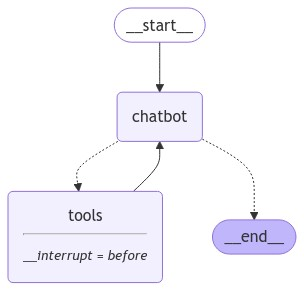

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
snapshot = graph.get_state(config)
print(snapshot.values["messages"][-3:])
print(snapshot.next)

[ToolMessage(content='랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다', id='69859f3c-907d-4679-8a07-aae03651d304', tool_call_id='call_N9E5wxGaTBpZudPU5IkiRBac'), AIMessage(content='랭그래프는 stateful, multi-actor LLM applications 를 만드는 라이브러리 란다', additional_kwargs={}, response_metadata={}, id='262a50f2-1c44-41f6-a34b-9d20353c23a4'), AIMessage(content="I'm an AI expert!", additional_kwargs={}, response_metadata={}, id='1666e433-9d66-4fd2-a4ff-464a33564ca7')]
()


#### Message 를 덧붙이는게 아니라 **overwrite** 하고 싶다면?

[`add_messages`](https://langchain-ai.github.io/langgraph/reference/graphs/?h=add+messages#add_messages) 함수는 `State` 에 메세지를 `append` 하지만, ID 를 찾아서 일치하는게 있으면 overwrite 를 합니다, 자세한 동작은 공식 문서 링크를 참조하세요.

이를 이용하면, 원하는대로 동작을 바꿔줄 수 있겠죠. 다시 질문부터 해보겠습니다.

In [ ]:
user_input = "나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?"
config = {"configurable": {"thread_id": "4"}}  # we'll use thread_id = 4 here
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

나는 지금 랭그래프를 배우고 있는데, 대신 조사 좀 해줄래?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_85Z84vjd60rJ18pWRb00GuWI)
 Call ID: call_85Z84vjd60rJ18pWRb00GuWI
  Args:
    query: 랭그래프 랭크그래프 배우기


**Next,** 이번에는 쿼리가 이렇게 나왔어요.
  - "랭그래프 랭크그래프 배우기"

쿼리가 마음에 안듧니다. 바꿔서 이어가겠습니다.

In [ ]:
from langchain_core.messages import AIMessage

snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
print("Original")
print("Message ID", existing_message.id)
print(existing_message.tool_calls[0])
new_tool_call = existing_message.tool_calls[0].copy()
new_tool_call["args"]["query"] = "랭그래프 Langgraph 사용법"
new_message = AIMessage(
    content=existing_message.content,
    tool_calls=[new_tool_call],
    # Important! The ID is how LangGraph knows to REPLACE the message in the state rather than APPEND this messages
    id=existing_message.id,
)

print("Updated")
print(new_message.tool_calls[0])
print("Message ID", new_message.id)
graph.update_state(config, {"messages": [new_message]})

print("\n\nTool calls")
graph.get_state(config).values["messages"][-1].tool_calls

Original
Message ID run-29a7fc2d-236d-44a3-80ec-bbda0576d745-0
{'name': 'tavily_search_results_json', 'args': {'query': '랭그래프 Langgraph 사용 법'}, 'id': 'call_85Z84vjd60rJ18pWRb00GuWI', 'type': 'tool_call'}
Updated
{'name': 'tavily_search_results_json', 'args': {'query': '랭그래프 Langgraph 사용법'}, 'id': 'call_85Z84vjd60rJ18pWRb00GuWI', 'type': 'tool_call'}
Message ID run-29a7fc2d-236d-44a3-80ec-bbda0576d745-0


Tool calls


[{'name': 'tavily_search_results_json',
  'args': {'query': '랭그래프 Langgraph 사용법'},
  'id': 'call_85Z84vjd60rJ18pWRb00GuWI',
  'type': 'tool_call'}]

**Notice**

'랭그래프 Langgraph 사용법' 이라고 쿼리 내용을 바꿔 봤습니다.

[LangSmith trace](https://smith.langchain.com/public/f651a4fe-73a1-416e-b028-908bdd68e16c/r) 을 체크해보면, 다음 tool 호출에 날려야할 쿼리가 바뀐 것을 볼 수 있어요.

graph.stream 을 이어가겠습니다. 메세지는 있던 것을 교체했으니 다시 추가로 넣을 것은 없습니다. None 을 추고 이어가겠습니다.


In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_85Z84vjd60rJ18pWRb00GuWI)
 Call ID: call_85Z84vjd60rJ18pWRb00GuWI
  Args:
    query: 랭그래프 Langgraph 사용법
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://www.datacamp.com/tutorial/langgraph-tutorial", "content": "LangGraph is a library within the LangChain ecosystem designed to tackle these challenges head-on. LangGraph provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured manner. It simplifies the development process by enabling the creation of cyclical graphs, which are essential for developing ..."}, {"url": "https://langchain-ai.github.io/langgraph/how-tos/", "content": "One of LangGraph's main benefits is that it makes human-in-the-loop workflows easy. These guides cover common examples of that. How to add breakpoints

최종 [trace](https://smith.langchain.com/public/8de0bfc5-5420-4122-8bbe-285fa33cebf5/r) 를 보면, 첫 질문에 이어서 쿼리가 바뀌고 tool 이 호출되고, 그 검색결과로 답변한 것을 볼 수 있습니다.

이 그래프에 이어서 질문을 해보면, memory 에 들어간 내용을 참조해서 답변을 하는 것을 볼 수 있습니다.

In [ ]:
events = graph.stream(
    {
        "messages": (
            "user",
            "자 너는 뭘 배웠지?",
        )
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

자 너는 뭘 배웠지?
================================== Ai Message ==================================

랭그래프(Langgraph)에 대해 배운 내용은 다음과 같습니다:

1. **정의 및 목적**: 랭그래프는 LangChain 생태계의 일부로, 여러 LLM(대형 언어 모델) 에이전트나 체인을 정의하고 조정하는 데 도움을 주는 라이브러리입니다. 이를 통해 복잡한 작업을 구조적으로 처리할 수 있습니다.

2. **기능**: 랭그래프는 순환 그래프를 생성할 수 있는 기능을 제공하여 개발자가 다양한 작업 흐름을 쉽게 구성할 수 있도록 합니다. 또한, 인간의 개입이 필요한 작업 흐름을 쉽게 만들 수 있는 다양한 도구와 방법을 지원합니다.

3. **유용한 자료**: 랭그래프에 대한 튜토리얼과 How-To 가이드가 제공되어 사용자가 쉽게 배울 수 있도록 돕고 있습니다. 여기에는 중단점 추가, 그래프 상태 편집, 과거 그래프 상태 보기 및 업데이트하기와 같은 기능이 포함됩니다.

이 정보들은 랭그래프를 배우는 데 중요한 기초가 될 수 있습니다. 더 궁금한 점이나 추가적으로 알고 싶은 내용이 있으면 말씀해 주세요!


자. 여기까지 Agent 수행 중 개입에 성공했습니다.  
원하는 대로 중간에 들어가서 멈추고, 바꾸고 싶은 것 바꾸고, 이어가고 모두 다 가능합니다.  
이 정도면 꽤나 자유도가 생겨서 원하는 것들을 구현하는 것이 가능합니다.   

또 다시 제 의견 첨언하자면,
  - Agent 의 문제는 컨트롤이 너무 힘들다는 점 이었습니다.  
    - 일을 잘하는 것 같으면서도, 가끔씩 고장나기도 하고, 복잡한 것은 잘 못하기도 합니다.  
  - 이렇게 개입 창구를 만들어두면, 많은 보완이 가능해서 진짜로! 매우! 유용합니다.  



## 6. Customizing State

지금까지는 State 가 단순 메세지만 담고 있었죠?  
State 에 더 많은 정보를 담아서 복잡한 일을 시켜 보도록 하겠습니다.  

앞선 파트까지는 "항상" interrupt 가 되어서 사람이 개입하도록 했죠.  이번에는 사람에게 요청을 할지, 알아서 할지, LLM 이 판단하도록 해보겠습니다.  

이를 구현하기 위한 첫번째 방법은 "Human" 노드를 만들어서 그 때 멈추도록하는 것입니다. "Human" tool 을 LLM 이 부르면 "Human" 노드로 그래프가 가고, 멈추도록 하는 것이죠.  

`State` 에 `ask_human` 멤버 변수를 추가하겠습니다.

In [ ]:
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag is new
    ask_human: bool

`BaseModel` 을 상속받아서 Human 에게 요청할 때 보낼 통로를 만들어줍니다.  
이 클래스는 `tool`  자리입니다.

In [ ]:
from langchain_core.pydantic_v1 import BaseModel


class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """

    request: str

/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


`chatbot` 노드를 다시 만들겠습니다.
- `llm` 에 `bind_tools()` 할 때, 위에서 만든 모델을 추가하고,
- `ask_human` 플래그를 llm 이 부르려고 한다면, `true` 로 켜주는 코드를 넣습니다.


In [ ]:
tool = TavilySearchResults(max_results=2)
tools = [tool]

# We can bind the llm to a tool definition, a pydantic model, or a json schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

이어서 그래프도 만들어 줍니다.  tools 노드는 tavily tool 을 만들어주고요, 이따 아래에서 human 노드를 따로 추가합니다.

In [ ]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=[tool]))

`human` 노드를 만들어 줍니다.

`human` 노드 함수는 interrupt 가 걸려서 사람에게 전달 될 테지만, 혹시라도 사람이 state 를 변경하지 않았다면, 그 사실을 메세지에 추가하도록 하게습니다.
그리고, 다시 state 에서 `ask_human` 플래그는 false 로 꺼줍니다.

In [ ]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to
        # let the LLM continue.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

이번엔 노드 선택 로직을 추가하겠습니다.
`select_next_node` 가 필요하면 `human` 노드로 보내줍니다.
그게 아니라면, 이전 처럼 'tools_condition' 으로 보냅니다.

`tools_condition` 은 `tool_calls` 의 답변을 받았는지 보고, `action` 노드로 보내거나 그래프를 끝냅니다.

In [ ]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, we can route as before
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

 항상 되돌려 보내는 edge 들을 추가해주고 마무리합니다.
 `human` 노드 전에는 꼭 interrupt 하고요.

In [ ]:
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

visualize 하면 아래와 같이 생겼습니다.

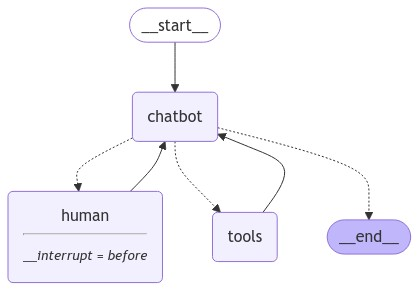

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

이제 그래프르르 실행시켜보겠습니다.

In [ ]:
user_input = "AI agent 만드는 데 도움 좀 줘봐라!"
config = {"configurable": {"thread_id": "5"}}
# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

AI agent 만드는 데 도움 좀 줘봐라!
================================== Ai Message ==================================
Tool Calls:
  RequestAssistance (call_5DIhb5uSzfqjaR527dQuEdZs)
 Call ID: call_5DIhb5uSzfqjaR527dQuEdZs
  Args:
    request: AI agent 만드는 방법에 대해 자세히 설명해 주세요. 필요한 기술, 도구, 언어, 그리고 프로젝트의 주요 단계에 대해 알려 주세요.


다음 도구로 Human 을 뽑았습니다. request 문구도 써줬고요, interrupt 가 되었습니다.

In [ ]:
snapshot = graph.get_state(config)
snapshot.next

('human',)

이제 우리가 Human Expert 가 되어서 대답을 해줍니다.

1. `ToolMessage` 에 할말을 답아서 추가합니다, 자연스래 `chatbot` 노드로 넘어가죠.
2. `update_state` 를 호출에서 메세지를 업데이트 해주겠습니다.

In [ ]:
ai_message = snapshot.values["messages"][-1]
human_response = (
    "내가 전문가야. LangGraph 를 사용하면 AI Agent를 쉽게 잘 만들수가 있지."
)
tool_message = create_response(human_response, ai_message)
graph.update_state(config, {"messages": [tool_message]})

{'configurable': {'thread_id': '5',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef75a12-c4a7-69e5-8002-83c61e7b0665'}}

In [ ]:
graph.get_state(config).values["messages"]

[HumanMessage(content='AI agent 만드는 데 도움 좀 줘봐라!', additional_kwargs={}, response_metadata={}, id='2a2cec0b-b816-4e09-8c05-b7127d0b1903'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5DIhb5uSzfqjaR527dQuEdZs', 'function': {'arguments': '{"request":"AI agent 만드는 방법에 대해 자세히 설명해 주세요. 필요한 기술, 도구, 언어, 그리고 프로젝트의 주요 단계에 대해 알려 주세요."}', 'name': 'RequestAssistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 45, 'prompt_tokens': 153, 'total_tokens': 198, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_483d39d857', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-02921127-a8e4-4d78-89ba-065ec995e60d-0', tool_calls=[{'name': 'RequestAssistance', 'args': {'request': 'AI agent 만드는 방법에 대해 자세히 설명해 주세요. 필요한 기술, 도구, 언어, 그리고 프로젝트의 주요 단계에 대해 알려 주세요.'}, 'id': 'call_5DIhb5uSzfqjaR527dQuEdZs', 'type': 'tool_call'}], usage_metadata={'input_tokens': 15

 **resume** 하겠습니다.  
 역시나 stream 을 이어가는데 메세지는 이미 추가했으니 `None` 을 넣어주면 됩니다.

In [ ]:
events = graph.stream(None, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================

내가 전문가야. LangGraph 를 사용하면 AI Agent를 쉽게 잘 만들수가 있지.
================================= Tool Message =================================

내가 전문가야. LangGraph 를 사용하면 AI Agent를 쉽게 잘 만들수가 있지.
================================== Ai Message ==================================

AI 에이전트를 만드는 데 LangGraph를 사용하는 방법은 다음과 같습니다:

1. **LangGraph 소개**: LangGraph는 자연어 처리(NLP) 모델을 쉽게 구축하고 실행할 수 있도록 도와주는 프레임워크입니다. 이를 통해 복잡한 AI 에이전트를 간편하게 만들 수 있습니다.

2. **필요한 기술 및 도구**:
   - **프로그래밍 언어**: Python은 NLP 및 AI 개발에 널리 사용됩니다.
   - **라이브러리**: TensorFlow, PyTorch, Hugging Face Transformers 등과 같은 머신러닝 라이브러리를 사용할 수 있습니다.
   - **LangGraph**: LangGraph 프레임워크를 설치하고 활용합니다.

3. **주요 단계**:
   - **목표 설정**: AI 에이전트가 수행할 작업과 기능을 정의합니다.
   - **데이터 수집**: 모델 훈련에 사용할 데이터셋을 수집합니다.
   - **모델 선택**: 적합한 NLP 모델을 선택합니다.
   - **모델 훈련**: 선택한 모델을 LangGraph를 사용하여 훈련합니다.
   - **테스트 및 평가**: 훈련된 모델을 테스트하고 성능을 평가합니다.
   - **배포**: 최종 모델을 실제 환경에 배포합니다.

4. **추가 자료**: Lang

[LangSmith Trace](https://smith.langchain.com/public/8de0bfc5-5420-4122-8bbe-285fa33cebf5/r) 를 참고해보면, Human 노드에서 결과를 얻어 대답을 이어간 것을 확인 할 수 있습니다.  



여기까지 LangGraph 의 기본적인 사용법 이었습니다.  
공식 튜토리얼에는 과거 시점으로 돌아가서 이어가는 내용도 있긴 한데, 이 외에도 수많은 디테일들이 있으므로, 본 문서는 여기서 마치고, 추가 자료들로 이어서 소개하겠습니다.  